In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
edgecolors= ['k' , 'r', 'g' , 'c' , 'm' , 'y', 'b']
lumi = 1298.1

Import the helper functions library


In [2]:
import helpers as hp

Binning for the myy plot

In [4]:
binning = np.linspace(100, 3100, num=121)

In [7]:
observables = ["photon1_pT", "photon2_pT", "photon1_phi", "photon2_phi", "photon1_eta", "photon2_eta", "dEta", "n_jets", "average_jet_pT", "lead_jets_dPhi", "n_leptons", "photon1_isolation", "photon2_isolation", "missing_energy"]

In [8]:
samples = ["datasets/signal_500.csv","datasets/signal_750.csv", "datasets/signal_1000.csv", "datasets/background.csv"]
sampleDict = {}

for sample in samples:
  sample_name = sample.split("/")[-1].split(".csv")[0]
  sampleDict[sample_name] = pd.read_csv(sample)

cross_sections_times_filter_eff_by_total_N ={
"background": 1286.5*0.081/len(sampleDict["background"]),
"signal_1000":5.4*0.17/len(sampleDict["signal_1000"]),
"signal_750":5.4*0.17/len(sampleDict["signal_750"]),
"signal_500":5.4*0.17/len(sampleDict["signal_500"]),
}


# Task 1 and 2 make a plot of the sideband and fit it

First, apply our mask for the full selection derived last time

In [12]:
for sample_name in sorted(sampleDict.keys()):
  ds = sampleDict[sample_name]
  sampleDict[sample_name]["myy"] = ( 2 * ds["photon1_pT"]  * ds["photon2_pT"]  * (np.cosh(ds["photon1_eta"] - ds["photon2_eta"]) - np.cos((ds["photon1_phi"] - ds["photon2_phi"])))) ** 0.5
  sampleDict[sample_name]["weights"] = lumi*cross_sections_times_filter_eff_by_total_N[sample_name]*np.ones(len(ds))
  mask = np.ones(len(ds)).astype(bool)
  mask *= sampleDict[sample_name]['photon1_isolation'] > 0.49
  mask *= sampleDict[sample_name]['photon1_isolation'] < 0.87
  mask *= sampleDict[sample_name]['photon2_isolation'] > 0.47
  mask *= sampleDict[sample_name]['photon2_isolation'] < 0.88
  mask *= sampleDict[sample_name]['n_jets'] < 4
  mask *= sampleDict[sample_name]['average_jet_pT']  >43.4
  mask *= sampleDict[sample_name]['lead_jets_dPhi']  > -0.77
  mask *= sampleDict[sample_name]['lead_jets_dPhi']  < 6.29
  mask *= sampleDict[sample_name]['n_leptons']  < 1.41
  mask_sr = mask * sampleDict[sample_name]["myy"] >400
  mask_sr *= sampleDict[sample_name]["myy"] < 1100
  mask_cr = mask * np.logical_or( sampleDict[sample_name]["myy"] <400 , sampleDict[sample_name]["myy"] > 1100)
  # save the masks for the selection, sideband (=Control Region CR) and SR (search region) as columns!
  sampleDict[sample_name]["SR"] =  mask_sr
  sampleDict[sample_name]["sideband"] =  mask_cr
  sampleDict[sample_name]["selection"] =  mask




Our yield estimate is 3578.9982 +/- 109.4550
Parameters for Expo: 
Param 0 : 783.578951 +/- 14.304606
Param 1 : 0.002598 +/- 0.000035


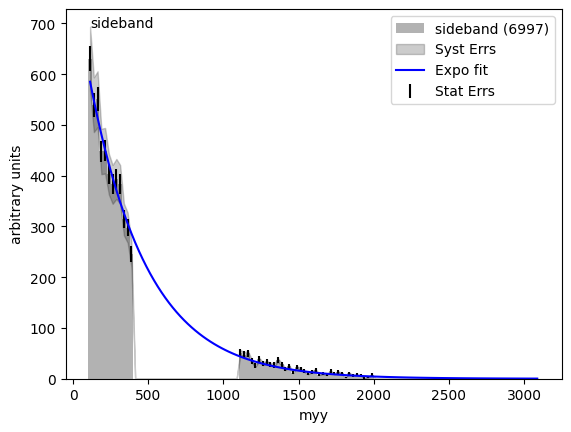

<Figure size 640x480 with 0 Axes>

In [38]:
bkgest, bkgest_err = 0, 0

def draw_myy(sample, region, label="", function=hp.Expo):
  global bkgest, bkgest_err
  if label=="": label=region
  i = 0
  obs="myy"
  s_data = sample

  mask = s_data[region]
  data = np.array(s_data[obs][mask ])

  n, bins, _ = plt.hist(data, binning, label = "%s (%d)" % (label, s_data['weights'][mask].sum()), alpha=0.3,  histtype='stepfilled', color=edgecolors[i], weights=s_data['weights'][mask])
  mid = 0.5*(bins[1:] + bins[:-1])
  lab_stat = None
  lab_syst = None
  if i==0 :
    lab_stat = "Stat Errs"
    lab_syst = "Syst Errs"
  plt.errorbar(mid, n, yerr=n**0.5, fmt='none', label=lab_stat, color=edgecolors[i])
  plt.fill_between(mid, n*0.9, n*1.1, color=edgecolors[i], alpha=0.2, label= lab_syst)
  plt.annotate(label, xy=(0.05, 0.95), xycoords='axes fraction')

  plt.ylabel("arbitrary units")
  plt.xlabel(obs)
  x, params, errs = hp.do_fit(function, bins, n)
  bkgest, bkest_stat_err =  hp.integral_with_errors(function, x, (400,1100), params, errs)
  bkgest_syst_err = 0.01*bkgest
  bkgest_err = ((0.01*bkgest)**2 + bkest_stat_err**2)**0.5
  plt.plot(x, function(x, *params), '-', color="blue", label = "%s fit" % function.__name__)
  if  "Gaus" in function.__name__:
    print("========Fitted signal========")
    y, ye = hp.integral_with_errors(hp.Gaussian, x, (400,1100), params[:3], errs[:3])
    xsFactor = 5.4/613. # this depends on your own cuts 
    print("measured yield: %.2f +/- %.2f " % ( y, ye))
    print("measured cross-section: %.2f +/- %.2f pb" % (  y*xsFactor, ye*xsFactor))
    print("measured mass: %.2f +/- %.2f GeV" % ( params[0], errs[0]))
    print("measured width: %.2f +/- %.2f GeV" % ( params[1], errs[1]))
    print("measured const: %.2f +/- %.2f" % ( params[2], errs[2]))
  if function.__name__ == "Expo":
    print ("Our yield estimate is %.4f +/- %.4f" % (bkgest, bkgest_err))
  print ("Parameters for %s: " % (function.__name__))
  for ip, (p,e) in  enumerate(zip(params, errs)):
    print("Param %d : %f +/- %f" % (ip, p, e))
  plt.legend()
  plt.show()
  plt.clf()
  return n, bins, params, errs


n, bins, params, errs = draw_myy(sampleDict["background"],  "sideband")

# Task 3: calculate significance of an excesss

In [39]:
# a) when you comapre to just the bkg sample
sample = sampleDict["background"]
n_obs = sample['weights'][sample["SR"]].sum()
significance =  abs(n_obs - bkgest) / bkgest_err
print ("SM only: obs = %.2f"% n_obs, " exp = %.2f +/- %.2f "% (bkgest, bkgest_err),   " s=%.1f sigma"% significance)


# b) when you comapre to bkg+nominal signal
sample = pd.concat([sampleDict["background"], sampleDict["signal_1000"]], ignore_index=True)
n_obs = sample['weights'][sample["SR"]].sum()
significance =  abs(n_obs - bkgest) / bkgest_err
print ("SM+X1000 only: obs = %.2f"% n_obs, " exp = %.2f +/- %.2f "% (bkgest, bkgest_err),   " s=%.1f sigma"% significance)


# c) when you comapre to bkg+ signal with half the cross-section
sigsample = sampleDict["signal_1000"].copy()
sigsample["weights"] *= 0.5
sample = pd.concat([sampleDict["background"], sigsample], ignore_index=True)
sample_750 = pd.concat([sampleDict["background"], sampleDict["signal_750"]], ignore_index=True)
n_obs = sample['weights'][sample["SR"]].sum()
significance =  abs(n_obs - bkgest) / bkgest_err
print ("SM+X1000 (mu=0.5): obs = %.2f"% n_obs, " exp = %.2f +/- %.2f "% (bkgest, bkgest_err),   " s=%.1f sigma"% significance)


SM only: obs = 3645.54  exp = 3579.00 +/- 109.46   s=0.6 sigma
SM+X1000 only: obs = 4258.17  exp = 3579.00 +/- 109.46   s=6.2 sigma
SM+X1000 (mu=0.5): obs = 3951.85  exp = 3579.00 +/- 109.46   s=3.4 sigma


# Task 4: Fit the signal Gaussian, and Signal on top of backgrounds (Gaus+Expo)
And extract number of measured signal events, mass etc

In [40]:
# fix the Exponenetial values
hp.fixedExpoN=783.5790
hp.fixedExpoL=0.002598


========Fitted signal========
measured yield: 612.42 +/- 36.49 
measured cross-section: 5.39 +/- 0.32 pb
measured mass: -1000.19 +/- 1.24 GeV
measured width: 30.49 +/- 0.89 GeV
measured const: 200.30 +/- 9.96
Parameters for Gaussian: 
Param 0 : -1000.188508 +/- 1.235835
Param 1 : 30.489291 +/- 0.887570
Param 2 : 200.298759 +/- 9.959633


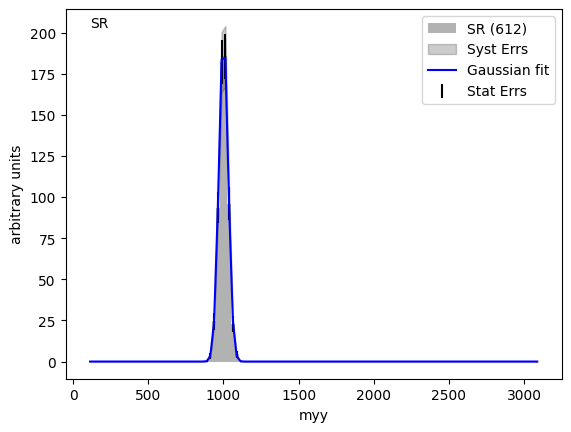

<Figure size 640x480 with 0 Axes>

In [41]:
# Fit the 1000-GeV signal to a singple Gaussian
n, bins, params, errs  = draw_myy(sampleDict["signal_1000"] , "SR", function=hp.Gaussian)
# we retrieve the correct abs(mass)

========Fitted signal========
measured yield: 614.85 +/- 57.17 
measured cross-section: 5.42 +/- 0.50 pb
measured mass: 748.78 +/- 2.12 GeV
measured width: 30.61 +/- 1.97 GeV
measured const: 200.01 +/- 13.85
Parameters for GausPlusFixedExpo: 
Param 0 : 748.782297 +/- 2.123670
Param 1 : 30.610830 +/- 1.966178
Param 2 : 200.013865 +/- 13.845888


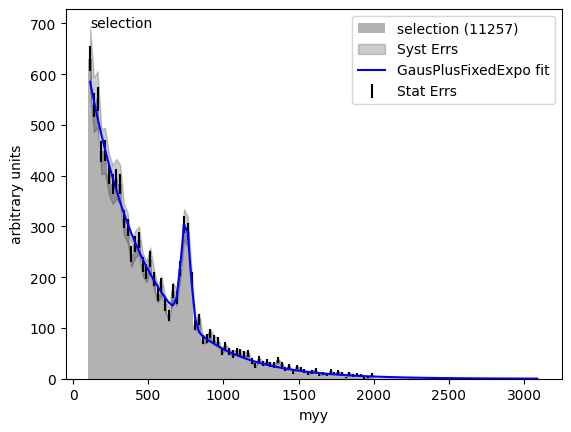

<Figure size 640x480 with 0 Axes>

In [42]:
# Fit the dataset composed of background+signal_750 to Gaussian on top of Fixed exponential, and make sure we get the right boson mass
n, bins, params, errs  = draw_myy(sample_750 , "selection", function=hp.GausPlusFixedExpo)


========Fitted signal========
measured yield: 332.36 +/- 43.65 
measured cross-section: 2.93 +/- 0.38 pb
measured mass: 998.16 +/- 3.33 GeV
measured width: 34.63 +/- 3.10 GeV
measured const: -96.43 +/- 9.23
Parameters for GausPlusFixedExpo: 
Param 0 : 998.155602 +/- 3.327972
Param 1 : 34.632336 +/- 3.099997
Param 2 : -96.431831 +/- 9.226007


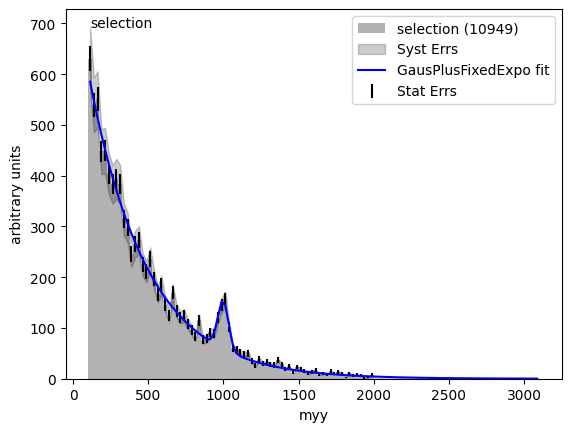

<Figure size 640x480 with 0 Axes>

In [43]:
# do the same with the sample with a half-crosssection
n, bins, params, errs  = draw_myy(sample , "selection", function=hp.GausPlusFixedExpo)

# Task 5: Claculate a limit on the cross-section if there is no excess

Nominal signal (μ = 1)      Observed CLs: 0.000006
Nominal signal (μ = 1) Expected CLs(-2 σ): 0.000000
Nominal signal (μ = 1) Expected CLs(-1 σ): 0.000000
Nominal signal (μ = 1) Expected CLs( 0 σ): 0.000001
Nominal signal (μ = 1) Expected CLs( 1 σ): 0.000037
Nominal signal (μ = 1) Expected CLs( 2 σ): 0.001354
Upper limit (obs): μ = 0.4864
Upper limit (exp): μ = 0.3992


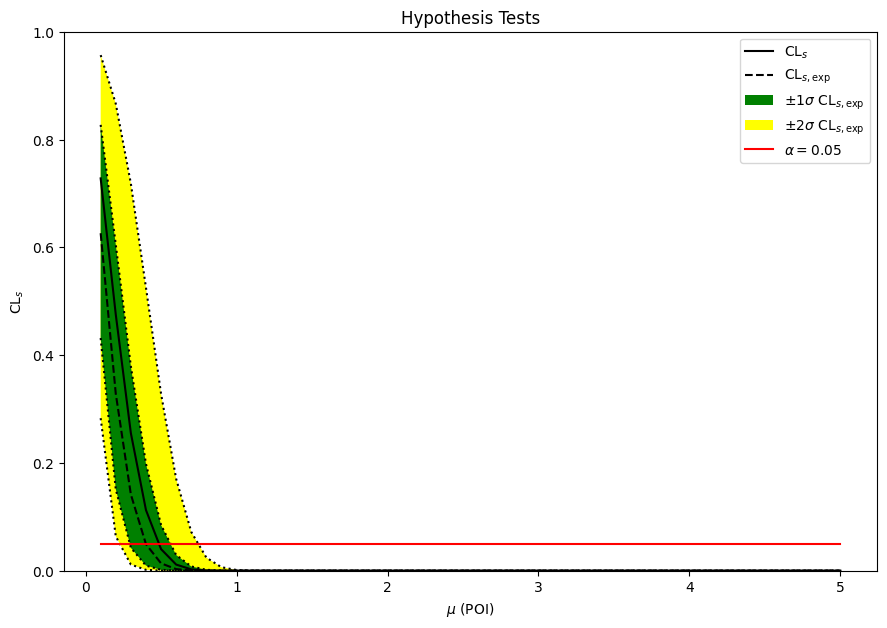

In [48]:
hp.cls_limit_calculator([612.63], [3574.9948], [110], [3645.54])

This means you can exclude signals of strength above 0.5 or so (ie cross-sections above 5.4 * 0.5  to 2.7)